![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 06 - Convolutional Neural Network</center>
### <center> 1D convolution and Introduction to Pytorch</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/Main1D_CnnAndPytorch1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

### Generate some data (for frequency estimation):
$$\boldsymbol{x}_{i}\left(t\right)=\sin\left(2\pi f_{i}t+\phi_{i}\right)+n_{i}\left(t\right)$$
**Input**: The signal $x_i(t)$  
**Output**.: The signal frequency $f_i$  


We will use `torch.tensor`, which is very similar to `numpy.ndarray`

In [4]:
Ntrain   = 10000 #-- number of training points
Fs       = 100   #-- sample frequency
T        = 5     #-- observation time (sec)
noiseStd = 0.1

t    = torch.linspace(0, T, T * Fs)   #-- time axis
vF   = torch.rand(Ntrain) * Fs / 30   #-- frequencies
vPhi = 2 * np.pi * torch.rand(Ntrain) #-- random phase

#-- Generate signals: x_i(t) = sin(2π f_i t + φ_i) + n_i(t)
mX = torch.sin(2 * np.pi * vF[:,None] @ t[None,:] + vPhi[:,None])
mX = mX + noiseStd * torch.randn(mX.shape)                        #-- add noise

mX.shape, mX.size() #-- in PyTorch, we have both shape and size().

(torch.Size([10000, 500]), torch.Size([10000, 500]))

### Plot some examples:

Use `torch.Tensor.item()` to get a Python number from a tensor containing a single value:

In [5]:
#-- If we have a tensor 
idx1 = torch.tensor([7])
idx2 = torch.tensor([7]).item()
idx1, idx2

(tensor([7]), 7)

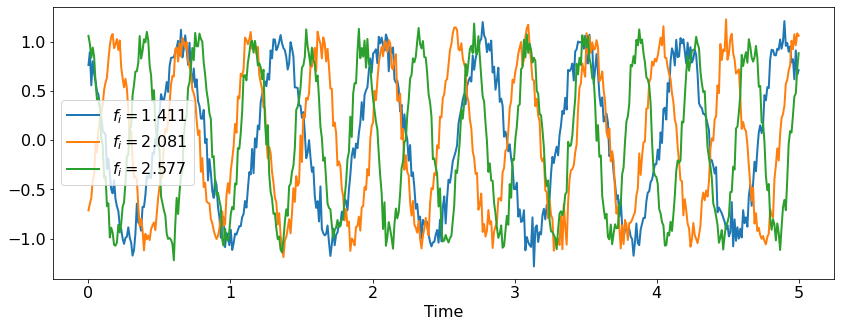

In [6]:
plt.figure(figsize=(14,5))
plt.xlabel('Time')
for _ in range(3):
    idx = torch.randint(0, Ntrain, (1,)).item()
    vX  = mX[idx,:]
    plt.plot(t, vX, lw=2, label=f'$f_i = {(vF[idx].item()):.3f}$')

plt.legend()
plt.show()

### Input data: (N x Channels X Length)
The input to 1D CNN is `NxCxL` so we use `view` to add a new axis (`unsqueeze` will work as well)


In [7]:
mX = mX.view(Ntrain,1,-1)
mX.shape #-- N x Channels x Length

torch.Size([10000, 1, 500])

### Split data to train and validation:

In [8]:
oDataSet            = torch.utils.data.TensorDataset(mX, vF)
N                   = len(oDataSet)
oTrainSet, oValSet  = torch.utils.data.random_split(oDataSet, np.round([0.9 * N, 0.1 * N]).astype(int))
len(oTrainSet), len(oValSet)

(9000, 1000)

### Create data loaders:

In [9]:
batchSize = 512
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize)

### Define the model (1D CNN):

In [10]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, input):
        out = input.view(input.size(0),-1)
        return out

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Just for the summary (identity):
class InputLayer(nn.Module):
    def forward(self, input):
        return input
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        InputLayer(), #-- does nothing
        
        nn.Conv1d(in_channels=1, out_channels=50, kernel_size=11),
        nn.MaxPool1d(kernel_size=2),
        nn.ReLU(),
                
        nn.Conv1d(in_channels=50, out_channels=100, kernel_size=11),
        nn.MaxPool1d(kernel_size=2),
        nn.ReLU(),

        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=11),
        nn.MaxPool1d(kernel_size=2),
        nn.ReLU(),

        nn.Conv1d(in_channels=200, out_channels=300, kernel_size=11),
        nn.MaxPool1d(kernel_size=2),
        nn.ReLU(),
                
        nn.AdaptiveAvgPool1d(output_size=1),
        Flatten(),
        nn.Linear(in_features=300, out_features=1),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), mX[0,:,:].shape, device='cpu')
print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─InputLayer: 1-1                        [-1, 1, 500]              --
├─Conv1d: 1-2                            [-1, 50, 490]             600
├─MaxPool1d: 1-3                         [-1, 50, 245]             --
├─ReLU: 1-4                              [-1, 50, 245]             --
├─Conv1d: 1-5                            [-1, 100, 235]            55,100
├─MaxPool1d: 1-6                         [-1, 100, 117]            --
├─ReLU: 1-7                              [-1, 100, 117]            --
├─Conv1d: 1-8                            [-1, 200, 107]            220,200
├─MaxPool1d: 1-9                         [-1, 200, 53]             --
├─ReLU: 1-10                             [-1, 200, 53]             --
├─Conv1d: 1-11                           [-1, 300, 43]             660,300
├─MaxPool1d: 1-12                        [-1, 300

### Record figures during training:

In [11]:
class Plot:
    def __init__(self, sTitle, sLabel, sXlabel, sColor, vData=[]):
        self.sTitle  = sTitle
        self.sLabel  = sLabel
        self.sXlabel = sXlabel
        self.sColor  = sColor
        self.vData   = vData

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Recorder:
    def __init__(self, lPlots, figsize=(12,4)):
        self.lTitles = np.unique([oPlot.sTitle for oPlot in lPlots])
        self.N       = len(self.lTitles)
        self.fig, _  = plt.subplots(1, self.N, figsize=(12, 4))
        self.dAxes   = {}
        ii           = 0
        for oPlot in lPlots:
            ax = self.dAxes.get(oPlot.sTitle, None)
            if ax == None:
                ax                       = self.fig.axes[ii]
                ii                      += 1
                self.dAxes[oPlot.sTitle] = ax

            ax.set_title(oPlot.sTitle)
            ax.set_xlabel(oPlot.sXlabel)
            ax.plot(oPlot.vData, c=oPlot.sColor, label=oPlot.sLabel)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()

    def Append(self, sTitle, sLabel, vData):
        ax = self.dAxes[sTitle]
        for oLine in ax.lines:
            if oLine.get_label() == sLabel:
                vYdata = np.append(oLine.get_ydata(), vData)
                N      = len(vYdata)
                oLine.set_data(list(range(N)), vYdata)
        lYlim = ax.axis()[2:4]
        ax.axis(xmin=0, xmax=N, ymin=np.minimum(np.min(vData), lYlim[0]), ymax=np.maximum(np.max(vData), lYlim[1]))

    def Draw(self):
        self.fig.canvas.draw()
        plt.pause(1e-10)

### Training loop:

In [12]:
import time

def TrainLoop(oModel, oTrainDL, LossFunc, oOptim):

    epochLoss = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(True)
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(device)
        vY = vY.to(device)

        #-- Set gradients to zeros:
        oOptim.zero_grad()
        
        #-- Forward:
        vHatY = oModel(mX).squeeze()
        loss  = LossFunc(vHatY, vY)

        #-- Backward:
        loss.backward()

        #-- Parameters update:
        oOptim.step()

        print(f'Iteration: {ii:3d}: loss = {loss.item():.6f}\r', end='')
        #-- Accumulate loss:
        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        count     += Nb

    epochLoss /= count

    return epochLoss

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValDL, LossFunc):

    epochLoss = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(False)
    
    #-- Iterate over the mini-batches:
    #-- During the validation, we do not neet to store gradients
    with torch.no_grad():
        for ii, (mX, vY) in enumerate(oValDL):
            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
            
            #-- Forward:
            vHatY = oModel(mX).squeeze()
            loss  = LossFunc(vHatY, vY)

            Nb         = mX.shape[0]
            epochLoss += Nb * loss.item()
            count     += Nb

    epochLoss /= count

    return epochLoss

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainModel(oModel, oTrainDL, oValDL, LossFunc, numEpochs, oOptim):

    oRecorder = Recorder([
        Plot('Loss', 'train', 'epoch', 'b'),
        Plot('Loss', 'val',   'epoch', 'r'),
    ])

    bestLoss = np.inf
    for epoch in range(numEpochs):
        startTime = time.time()
        trainLoss = TrainLoop(oModel, oTrainDL, LossFunc, oOptim) #-- train
        valLoss   = ValidationLoop(oModel, oValDL, LossFunc)      #-- validation

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Draw()

        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}',              end='')
        print(' | Val loss: '       f'{valLoss:.5f}',                end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |', end='')
        
        #-- Save best model:
        if valLoss < bestLoss:
            bestLoss   = valLoss
            try:
                torch.save(oModel.state_dict(), 'BestModelParameters.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print()
        

    oModel.load_state_dict(torch.load('BestModelParameters.pt'))

### Check whether GPU is available:

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda')

<IPython.core.display.Javascript object>


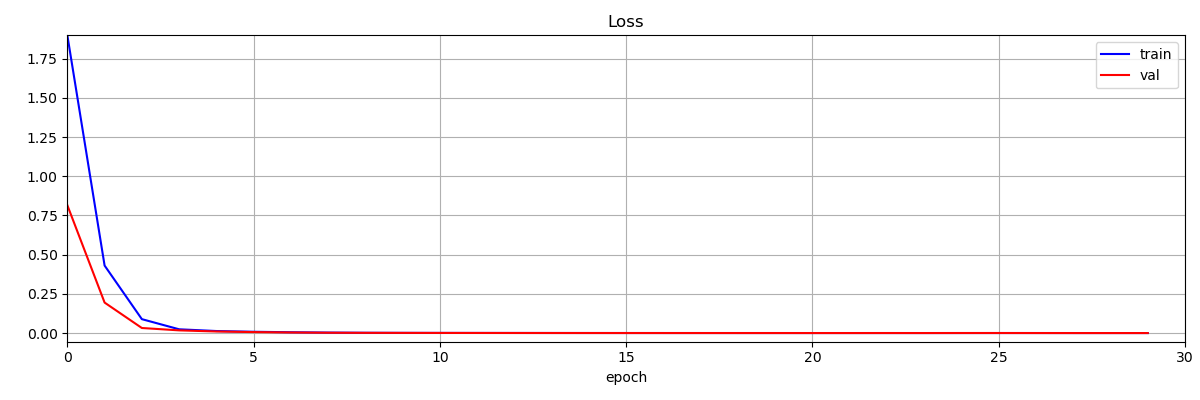

Epoch   0: | Train loss: 1.89890 | Val loss: 0.81536 | epoch time: 3.136 | <-- Checkpoint!
Epoch   1: | Train loss: 0.43066 | Val loss: 0.19461 | epoch time: 2.135 | <-- Checkpoint!
Epoch   2: | Train loss: 0.08893 | Val loss: 0.03251 | epoch time: 2.181 | <-- Checkpoint!
Epoch   3:  17: loss = 0.019297 | Train loss: 0.02427 | Val loss: 0.01740 | epoch time: 2.139 | <-- Checkpoint!
Epoch   4: | Train loss: 0.01319 | Val loss: 0.01025 | epoch time: 2.141 | <-- Checkpoint!
Epoch   5: | Train loss: 0.00847 | Val loss: 0.00647 | epoch time: 2.139 | <-- Checkpoint!
Epoch   6: | Train loss: 0.00543 | Val loss: 0.00392 | epoch time: 2.130 | <-- Checkpoint!
Epoch   7: | Train loss: 0.00330 | Val loss: 0.00231 | epoch time: 2.135 | <-- Checkpoint!
Epoch   8: | Train loss: 0.00210 | Val loss: 0.00159 | epoch time: 2.173 | <-- Checkpoint!
Epoch   9: | Train loss: 0.00156 | Val loss: 0.00124 | epoch time: 2.177 | <-- Checkpoint!
Epoch  10:  17: loss = 0.001070 | Train loss: 0.00123 | Val loss: 0.0

In [14]:
%matplotlib notebook

oModel   = GetModel().to(device)
oOptim   = optim.Adam(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99))
LossFunc = nn.MSELoss()
TrainModel(oModel, oTrainDL, oValDL, LossFunc, 30, oOptim)

### Test the model:

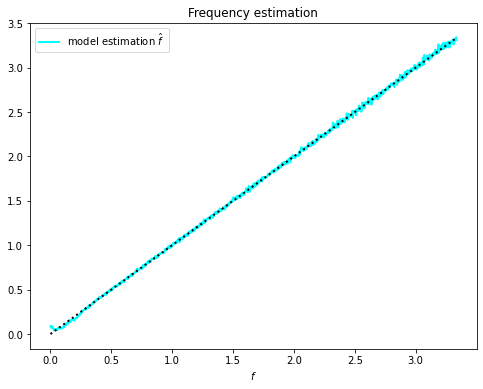

In [15]:
%matplotlib inline

Ntest     = 1001

#-- Generate test data:
vTestF = torch.linspace(0, Fs / 30, Ntest)
mTestX = torch.sin(2 * np.pi * vTestF[:,None] @ t[None,:])
mTestX = mTestX + noiseStd * torch.randn(mTestX.shape)

#-- Apply model:
vHatTestF = oModel(mTestX.view(Ntest,1,-1).to(device)).squeeze()
vHatTestF = vHatTestF.detach().cpu() #-- move to CPU

plt.figure(figsize=(8,6))
plt.plot(vTestF, vHatTestF, 'cyan', lw=2, label='model estimation $\hat{f}$')
plt.plot(vTestF, vTestF,   ':k',    lw=2)
plt.xlabel('$f$')
plt.title('Frequency estimation')
plt.legend()
plt.show()
